In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler
#!pip install imbalanced-learn
#!pip install statsmodels

In [2]:
# load data
aarp = pd.read_csv('Data/clean_AARP.csv')
aarp.head()

,Unnamed: 0,AGE4,INCOME,D6,D8,D9C,D18,D26,MARITAL,EDUC4,...,AGE4_recode,D6_recode,D8_recode,D9C_recode,D18_recode,D26_recode,MARITAL_recode,EDUC4_recode,RACETHNICITY_recode,GENDER_recode
0,0,60+,"$25,000 to $29,999",Good,Everyday,Never,Self-employed part-time,Rural area,Widowed,BA or above,...,4,3,7,1,1,1,1,4,1,1
1,1,60+,"$40,000 to $49,999",Very good,Several times a week,Rarely,Employed full-time,"Suburban with a mix of offices, apartments and...",Widowed,BA or above,...,4,4,6,2,2,2,1,4,1,2
2,2,30-44,"$100,000 to $124,999",Good,Once every 2 or 3 weeks,Sometimes,Unemployed and looking for work,Rural area,Never married,HS graduate or equivalent,...,2,3,4,3,6,1,2,2,1,1
3,3,30-44,"$200,000 or more",Very good,Everyday,Never,Self-employed full-time,"Urban near mix of offices, apartments and shops",Married,HS graduate or equivalent,...,2,4,7,1,7,2,3,2,2,2
4,4,45-59,"$150,000 to $174,999",Good,Several times a week,Never,Employed full-time,Suburban and mostly residential,Married,Some college,...,3,3,6,1,2,2,3,3,1,1


In [3]:
#looks like this isn't in the form we need it to be
aarp.dtypes

Unnamed: 0              int64
AGE4                   object
INCOME                 object
D6                     object
D8                     object
D9C                    object
D18                    object
D26                    object
MARITAL                object
EDUC4                  object
RACETHNICITY           object
GENDER                 object
HHSIZE                  int64
INCOME_recode           int64
AGE4_recode             int64
D6_recode               int64
D8_recode               int64
D9C_recode              int64
D18_recode              int64
D26_recode              int64
MARITAL_recode          int64
EDUC4_recode            int64
RACETHNICITY_recode     int64
GENDER_recode           int64
dtype: object

In [4]:
#found code to fix that

# list vars
model_vars = ['AGE4_recode', 'D6_recode', 'D8_recode', 'D9C_recode', 'D18_recode', 'D26_recode', 'MARITAL_recode', 'EDUC4_recode', 'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode']

# aarp be aarp
aarp = aarp[model_vars]

# recode D9C to binary
# if you never feel SI then 1, else 2, 
# then 0, 1 binary
aarp['is_si'] = aarp['D9C_recode'].apply(lambda x: 1 if x == 1 else 1 if x == 2 else 3)
aarp['is_si'] = aarp['is_si'].apply(lambda x: 0 if x == 1 else 1)

<AxesSubplot:>

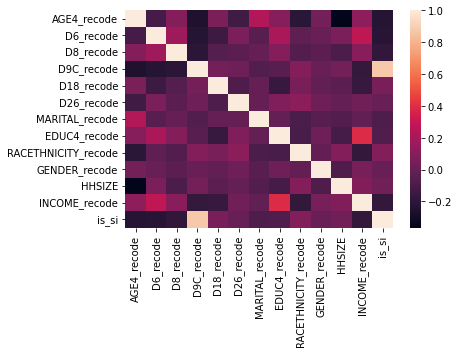

In [5]:
#correlation matrix to prepare for modeling
#D9C was used to make is_si, so thats fine and will be dropped
corr = aarp.corr()
sns.heatmap(corr)

In [6]:
#following Devins lead, recoding nominal variables into dummies
#I believe those are D18 D26 and Marital

aarp = pd.get_dummies(aarp, columns= ['D18_recode', 'D26_recode', 'MARITAL_recode'], prefix= ['D18', 'D26', 'Marital'], drop_first= True)
aarp.head()

,AGE4_recode,D6_recode,D8_recode,D9C_recode,EDUC4_recode,RACETHNICITY_recode,GENDER_recode,HHSIZE,INCOME_recode,is_si,...,D18_4,D18_5,D18_6,D18_7,D26_2,Marital_2,Marital_3,Marital_4,Marital_5,Marital_6
0,4,3,7,1,4,1,1,1,6,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,6,2,4,1,2,1,9,0,...,0,0,0,0,1,0,0,0,0,0
2,2,3,4,3,2,1,1,6,14,1,...,0,0,1,0,0,1,0,0,0,0
3,2,4,7,1,2,2,2,4,18,0,...,0,0,0,1,1,0,1,0,0,0
4,3,3,6,1,3,1,1,4,16,0,...,0,0,0,0,1,0,1,0,0,0


In [7]:
aarp.columns

Index(['AGE4_recode', 'D6_recode', 'D8_recode', 'D9C_recode', 'EDUC4_recode',
       'RACETHNICITY_recode', 'GENDER_recode', 'HHSIZE', 'INCOME_recode',
       'is_si', 'D18_2', 'D18_3', 'D18_4', 'D18_5', 'D18_6', 'D18_7', 'D26_2',
       'Marital_2', 'Marital_3', 'Marital_4', 'Marital_5', 'Marital_6'],
      dtype='object')

In [8]:
aarp.rename(columns={'D6_recode': 'Health', 'D8_recode': 'Contact', 'D18_2': 'Self-employed pt', 'D18_3':'Employed ft', 
                    'D18_4':'Employed pt', 'D18_5':'Retired', 'D18_6':'Unemployed', 'D18_7':'Unemployed-other',
                    'Marital_2':'Widowed', 'Marital_3':'Divorced', 'Marital_4':'Separated', 'Marital_5':'Never Married',
                     'Marital_6':'Partner', 'D26_2': 'Not Rural', 'AGE4_recode':'Age', 'EDUC4_recode':'Education',
                    'RACETHNICITY_recode':'Race', 'GENDER_recode':'Gender', 'INCOME_recode': 'Income'}, inplace=True)

In [9]:
aarp.columns

Index(['Age', 'Health', 'Contact', 'D9C_recode', 'Education', 'Race', 'Gender',
       'HHSIZE', 'Income', 'is_si', 'Self-employed pt', 'Employed ft',
       'Employed pt', 'Retired', 'Unemployed', 'Unemployed-other', 'Not Rural',
       'Widowed', 'Divorced', 'Separated', 'Never Married', 'Partner'],
      dtype='object')

In [10]:
#split into x and y for later modeling
x = aarp[['Age', 'Health', 'Contact', 'Education',
       'Race', 'Gender', 'HHSIZE', 'Income',
        'Self-employed pt', 'Employed ft', 'Employed pt', 'Retired',
       'Unemployed', 'Unemployed-other', 'Not Rural', 'Widowed', 'Divorced',
       'Separated', 'Never Married', 'Partner']]
y = aarp['is_si']

In [11]:
y.value_counts()

0    1305
1     616
Name: is_si, dtype: int64

In [12]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_x, os_y= os.fit_resample(x_train, y_train)

In [13]:
#it is balanced
os_y.value_counts()

1    926
0    926
Name: is_si, dtype: int64

In [14]:
#insignificant vars are: D8_recode, RACETHNICITY_recode, GENDER_recode, HHSIZE, D18_6, D26_2, Marital_5

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_x)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.621180
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                 1852
Model:                          Logit   Df Residuals:                     1832
Method:                           MLE   Df Model:                           19
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.1038
Time:                        13:41:38   Log-Likelihood:                -1150.4
converged:                       True   LL-Null:                       -1283.7
Covariance Type:            nonrobust   LLR p-value:                 1.344e-45
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Age                 -0.1665      0.063     -2.622      0.009      -0.291      -0.042
Health     

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#accuracy score
sk_logit = LogisticRegression()
sk_logit.fit(os_x, os_y)
y_pred = sk_logit.predict(x_test)

print('Accuracy on test set:{:.2f}'.format(sk_logit.score(x_test, y_test)))

Accuracy on test set:0.69


C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       379
           1       0.55      0.54      0.54       198

    accuracy                           0.69       577
   macro avg       0.65      0.65      0.65       577
weighted avg       0.69      0.69      0.69       577



In [17]:
for ages in aarp['Age'].unique():
    
    # grab aarp for single age group
    aged_aarp = aarp.loc[aarp['Age'] == ages]
    
    # split into train and test
    aarp_train, aarp_test = train_test_split(aged_aarp, test_size=0.33, random_state=42)
            
    # then create our imbalance object
    from imblearn.over_sampling import SMOTEN
    ab = SMOTEN(random_state=42)
    
    # manually create x,y test and trains
    x_train = aarp_train[['Age', 'Health', 'Contact', 'Education',
       'Race', 'Gender', 'HHSIZE', 'Income',
        'Self-employed pt', 'Employed ft', 'Employed pt', 'Retired',
       'Unemployed', 'Unemployed-other', 'Not Rural', 'Widowed', 'Divorced',
       'Separated', 'Never Married', 'Partner']]
    x_test = aarp_test[['Age', 'Health', 'Contact', 'Education',
       'Race', 'Gender', 'HHSIZE', 'Income',
        'Self-employed pt', 'Employed ft', 'Employed pt', 'Retired',
       'Unemployed', 'Unemployed-other', 'Not Rural', 'Widowed', 'Divorced',
       'Separated', 'Never Married', 'Partner']]
    y_train = aarp_train['is_si']
    y_test = aarp_test['is_si']
    
    x_train, y_train = ab.fit_resample(x_train, y_train)
    
    # new logistic regression model for p vals
    sk_logit = LogisticRegression()
    
    # let's 'train'
    sk_logit.fit(x_train, y_train)
    
    #import for stats model
    import statsmodels.api as sm
    
    # new logistic regression model for accuracy
    sm_logit = sm.Logit(y_train, x_train)
    result = sm_logit.fit()
    
    # print the results
    print(f'\n---------- score for age {ages}: {round(sk_logit.score(x_test, y_test),3)}% ----------')
    print(result.summary())
        
    ###### print train and test set sizes
    print(f'\ntraining set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 
    
    #Saving summary data to a dataframe for plots
    if ages==1.0:
        summary_df1 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if ages==2.0:
        summary_df2 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if ages==3.0:
        summary_df3 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if ages==4.0:
        summary_df4 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\potte\tools\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.419655
         Iterations: 35

---------- score for age 4: 0.712% ----------
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  506
Model:                          Logit   Df Residuals:                      486
Method:                           MLE   Df Model:                           19
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.3946
Time:                        13:41:44   Log-Likelihood:                -212.35
converged:                      False   LL-Null:                       -350.73
Covariance Type:            nonrobust   LLR p-value:                 1.120e-47
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Age                  2.3395      0.288      8.118      0.000       1.775       2.904


C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\potte\tools\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.460885
         Iterations: 35

---------- score for age 2: 0.652% ----------
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  482
Model:                          Logit   Df Residuals:                      462
Method:                           MLE   Df Model:                           19
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.3351
Time:                        13:41:46   Log-Likelihood:                -222.15
converged:                      False   LL-Null:                       -334.10
Covariance Type:            nonrobust   LLR p-value:                 5.684e-37
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Age                 12.3087    892.041      0.014      0.989   -1736.059    1760.676


C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\potte\tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Optimization terminated successfully.
         Current function value: 0.481582
         Iterations 8

---------- score for age 3: 0.619% ----------
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  442
Model:                          Logit   Df Residuals:                      422
Method:                           MLE   Df Model:                           19
Date:                Wed, 05 Apr 2023   Pseudo R-squ.:                  0.3052
Time:                        13:41:46   Log-Likelihood:                -212.86
converged:                       True   LL-Null:                       -306.37
Covariance Type:            nonrobust   LLR p-value:                 1.273e-29
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Age                  2.6965      0.492      5.476

In [18]:
#Create a new list to hold data that will be used for plotting
summary_plot = []

#Add a new column in each summary dataframe that indicates the Age group of the dataframe
summary_df1['Age Group'] = 1
summary_df2['Age Group'] = 2
summary_df3['Age Group'] = 3
summary_df4['Age Group'] = 4

for table in [summary_df1,summary_df2,summary_df3,summary_df4]:
    #Track the index
    index= 0
    
    for row in table['P>|z|']:
        if row <= .05:
            summary_plot.append(table.iloc[index])
        index+=1

In [19]:
summary_df = pd.DataFrame()
for each_df in summary_plot:
    summary_df = pd.concat([summary_df, each_df], axis=1 )
summary_df = summary_df.transpose()
summary_df['Age Group'] = summary_df['Age Group'].astype('int32')

[0.8027, 0.4366, 0.5314, 0.1925, 0.1225, 1.1457, 1.3094, 1.3509, 1.8284, 0.8027] [0.0, 0.6981317007977318, 1.3962634015954636, 2.0943951023931953, 2.792526803190927, 3.490658503988659, 4.1887902047863905, 4.886921905584122, 5.585053606381854, 0.0]


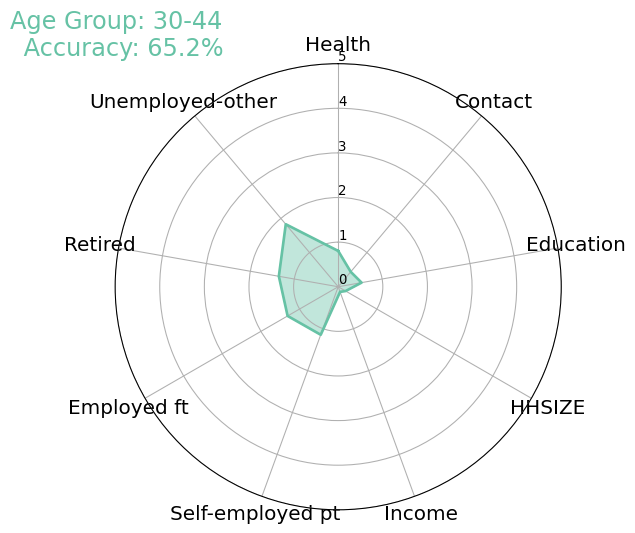

In [25]:
# plotting some radar plots?
# ne

# much courtesy of https://www.python-graph-gallery.com/392-use-faceting-for-radar-chart
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi



# categories are the var names
# only doing one group. Group A
# values is every value under A plus a repeat of the first (so it closes)
 

# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color, df):
    # number of variable
    categories=list(df.index)
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(2,2,row, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,1,2,3,4,5], ["0","1","2",'3','4','5'], color="black", size=10)
    plt.ylim(0,5)
    # Ind1
    #values=df.loc[row].drop('group').values.flatten().tolist()
    # values=df.iloc[:,row-1].tolist()
    values = abs(df['coef']).tolist()
    values += values[:1]
    print(f'{values} {angles}')
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    # Add a title
    plt.title(title, size=18, color=color, y=1.0,x=0.01)
    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1500/my_dpi, 1300/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(summary_df.index))
 
# # Loop to plot
# for row in range(0, len(df.index)):
#     make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
    
for row in summary_df['Age Group'].unique():
    title = ''
    if row == 1:
        title = '18-29 \n Accuracy: 63.5%'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 2:
        title = '30-44 \n Accuracy: 65.2%'
        make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        break
    if row == 3:
        title = '45-59 \n Accuracy: 61.9%'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    if row == 4:
        title = '60+ \n Accuracy: 70.9%'
        #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
        #break
    #make_spider( row=row, title=f'Age Group: {title}', color=my_palette(row), df = summary_df.loc[summary_df['Age Group'] == row])
    